Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones. But Kaymo ™ wants to stop that!

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim. While Kaymo ™ has used machine learning for the past 10 years, they’re looking to the CAIIS machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

## Initial data Analysis

First, we need to create the Spark Session

In [70]:
#In collab, we need to install everything:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.sonic.net/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xzf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"


import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

#In a native Jupyter notebook, we would simply do:
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('seedfinder').getOrCreate()

Afterwards, we can read the file and inspect it

In [71]:
#Please drop the file in the environments 'Files' panel
df = spark.read.options(header="true", inferSchema="true").csv("/content/train.csv")
df.describe().toPandas()

,summary,id,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18,cont_0,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,cont_10,target
0,count,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4065,4065,4065,4065,4065,4065
1,mean,3387.4498278406295,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.5051998947729144,0.49388336368386704,0.5189480562752655,0.4735777650650935,0.5086566082134892,0.5060181089955016,0.49226472593286386,0.5006876416744185,0.49040640920734324,0.4745391464905265,0.5064674250670175,0.18081180811808117
2,stddev,1935.5367394936904,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.20419268191081688,0.2109889750767605,0.2140486431630643,0.21460470991003147,0.22718105831759158,0.2395814912115326,0.21021050608421313,0.20111985652217018,0.18048630841199265,0.1951590751556047,0.20200775006813254,0.384909527996416
3,min,0,A,A,A,A,A,A,A,A,A,A,AA,A,A,A,A,A,A,A,A,-0.005136936996862684,0.10745448158938073,0.11502362274662108,0.006599651524877015,0.17695526722535196,-0.006380447747513784,0.021270552792613227,0.1223397138826129,0.0889069927983469,0.22995944353840855,0.1278528100161272,0
4,max,6757,B,O,U,N,T,ZZ,Y,Y,Y,X,Y,B,B,B,B,D,D,D,D,0.9953078039956524,0.9896946695363368,0.9917094757670126,0.92705434460466,0.8511866390241221,0.8423372084057961,0.957624056103622,1.0044606397161469,1.0414219123188158,0.9895323265306966,0.9925120037993798,1


As we can see, we have a database with 8 categotical variables, 11 continuous variables and a target value, which, in this training data, is provided so that we can train the algorithm. In this database, each row represents a given insurance policy, and target represents whether the policy resulted in a claim (1) or not (0). We want to predict whether a given insurance policy lead to claims, to remove that policies from the market and minimize the chance for costly, non-desirable claims.

Before proceeding with any approach, we first have to index the categorical variables! This is because pyspark and machine learning algorithms in general dont work well with strings: they need a mathematical value to work with. This has its own problems, specially since the numbers are not random and are orderable, but its the best we have.

In [72]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

#Bonus! Change this code to index multiple columns at once!
#And! With a list comprehension I can specify all the cat_ things from 1 to 18 :p
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in [f'cat_{x}' for x in range(19)] ]


pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)
df_indexed.describe().toPandas()

,summary,id,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18,cont_0,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,cont_10,target,cat_0_index,cat_1_index,cat_2_index,cat_3_index,cat_4_index,cat_5_index,cat_6_index,cat_7_index,cat_8_index,cat_9_index,cat_10_index,cat_11_index,cat_12_index,cat_13_index,cat_14_index,cat_15_index,cat_16_index,cat_17_index,cat_18_index
0,count,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4065,4065,4065,4065,4065,4065,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066,4066
1,mean,3387.4498278406295,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.5051998947729144,0.49388336368386704,0.5189480562752655,0.4735777650650935,0.5086566082134892,0.5060181089955016,0.49226472593286386,0.5006876416744185,0.49040640920734324,0.4745391464905265,0.5064674250670175,0.18081180811808117,0.24913920314805707,2.9648303000491882,1.5393507132316773,0.6000983767830792,1.3145597638957207,0.7845548450565667,0.7137235612395475,8.324643384161337,8.775454992621741,0.9473684210526315,19.2073290703394,0.1352680767338908,0.14240039350713232,0.02336448598130841,0.46532218396458436,0.34948352188883425,0.3462862764387605,0.2825873093949828,0.2147073290703394
2,stddev,1935.5367394936904,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.20419268191081688,0.2109889750767605,0.2140486431630643,0.21460470991003147,0.22718105831759158,0.2395814912115326,0.21021050608421313,0.20111985652217018,0.18048630841199265,0.1951590751556047,0.20200775006813254,0.384909527996416,0.4325677750396001,3.2452054039576987,2.4425605042547827,1.1474084345954927,1.7807690795360278,4.2299020498829245,1.380123728813704,9.875877537204804,9.154892230985055,1.8179599316104342,30.361885464393367,0.342051749318574,0.3495033102516255,0.15107680233781368,0.4988573482064128,0.565594945313189,0.5695057140802395,0.6398622202372004,0.5579704263968471
3,min,0,A,A,A,A,A,A,A,A,A,A,AA,A,A,A,A,A,A,A,A,-0.005136936996862684,0.10745448158938073,0.11502362274662108,0.006599651524877015,0.17695526722535196,-0.006380447747513784,0.021270552792613227,0.1223397138826129,0.0889069927983469,0.22995944353840855,0.1278528100161272,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,6757,B,O,U,N,T,ZZ,Y,Y,Y,X,Y,B,B,B,B,D,D,D,D,0.9953078039956524,0.9896946695363368,0.9917094757670126,0.92705434460466,0.8511866390241221,0.8423372084057961,0.957624056103622,1.0044606397161469,1.0414219123188158,0.9895323265306966,0.9925120037993798,1,1.0,14.0,16.0,12.0,18.0,56.0,14.0,50.0,53.0,16.0,184.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0


We now remove all the non-indexed (useless and repeated) columns from the original dataframe:

In [73]:
df_indexed = df_indexed.select([c for c in df_indexed.columns if c not in [f'cat_{x}' for x in range(19)]]) #Uses the same list comprehension as before!
#Note that I am keeping the ID. Since it is a unique identifyer, it would do nothing to help with prediction, but it doesnt harm either

Now, we have the indexed dataframe! We can proceed to do some exploratory analysis, to see what is the correlation between some of this parameters and the column of interest (target). For this, I'd usually plot the scatter matrix using pandas, but I have tried here and I have found that there are so many datapoints that the graph that appears is useless. Thus, I will plot a heatmap which tells me which variables are correlated to which 

In [74]:
#This is useless! Too much data!
#import pandas as pd
#pd.plotting.scatter_matrix(df.toPandas(), figsize=(10, 10));

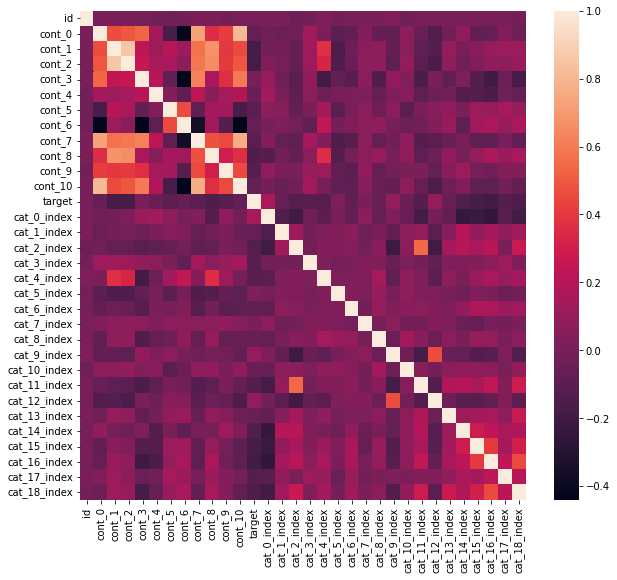

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9)) #Make the plot easier on the eyes
sns.heatmap(df_indexed.toPandas().corr())

As we can see, there is no clear correlation between any of the variables and the target parameter! This seems like a clear cut case for big data analysis, where we could try and see if each small correlation from each characteristic gets to add up and give us a good prediction after all!

## Supervised approach

One of the ways we can try and predict the outcome is through supervised learning. Here, we take a train data set, show the computer how to predict an outcome from this data, and then give it some data to make some predictions on it. 

Here, we are using three different methods, which come bundled with spark:


* [Decission Tree Classifier](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html): It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).
* [Random Forest Classifier](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html):  For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set.
* [Gradient Boosted Trees](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html): It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; it usually outperforms random forest.

We will use the three methods to find if their results match, and to pick the most accurate of the three.

First, we must first assemble a Vector with a "features" and a "label" tag so that it can be processed by Spark.

In [76]:
from pyspark.ml.feature import VectorAssembler, Imputer
assembler = VectorAssembler(inputCols= [e for e in df_indexed.columns if e not in ('target')]  , outputCol='features', handleInvalid='skip')
output = assembler.transform(df_indexed)
imputer = Imputer(inputCols=['target'], outputCols=['label'], strategy='mean')
imputer_model = imputer.fit(output)
output = imputer_model.transform(output)

Now that we have this set up, we can proceed to create the models:

In [77]:
#Fist, we alias the methods to make them easier to call
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
dtc = DecisionTreeClassifier(maxBins=185) #Decision Trees require maxBins to be at least as large as the number of values in each categorical feature
rfc = RandomForestClassifier(numTrees = 100, maxBins=185)
gbt = GBTClassifier(maxBins=185)

In [78]:
#We fit the three models
dtc_model = dtc.fit(output)
rfc_model = rfc.fit(output)
gbt_model = gbt.fit(output)

Now, we would like to get this model's predictions for our test data. First, we need to read the data:

In [84]:
#Please drop the file in the environments 'Files' panel
test_df = spark.read.options(header="true", inferSchema="true").csv("/content/test.csv")
test_df.describe().toPandas()

,summary,id,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18,cont_0,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,cont_10
0,count,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36737,36736,36736,36736,36736,36736,36736
1,mean,45565.33519340175,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.5063036234343945,0.49467192032599405,0.5173822226393028,0.4762916314739485,0.5033223270949208,0.5020626194199714,0.48730612112892824,0.5028144336472354,0.48923176796866097,0.4712561312748483,0.5094019115515299
2,stddev,26266.780527766103,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.20801235880562077,0.21322934164723154,0.2147802721260591,0.21726160996894317,0.22729116824926243,0.24097697602925358,0.2117830227977653,0.20422624901247177,0.1791202966152642,0.19567532832917978,0.20527800336854235
3,min,3,A,A,A,A,A,A,A,A,A,A,AA,A,A,A,A,A,A,A,A,-0.04726740437268828,0.09905764069525842,0.10521322746692256,-0.038177828728809315,0.17373018292252934,-0.03583375784982512,0.02298451094980952,0.09708227671225958,0.0280130873460242,0.22021805352799687,0.15451327463463016
4,max,91243,B,O,U,N,T,ZZ,Y,Y,Y,X,Y,B,B,B,B,D,D,D,D,0.9945586232209024,1.001207364106895,1.0105190260692984,0.9440372658550216,0.8541243700209937,0.8455319358435773,0.9646352575880386,1.0274581708548551,1.0434670315747987,0.9992554391006276,1.0066065913617064


We have to process it in the same way we processed the test data for it to work!

In [89]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(test_df) for column in [f'cat_{x}' for x in range(19)] ]
pipeline = Pipeline(stages=indexers)
test_df_indexed = pipeline.fit(test_df).transform(test_df)
test_df_indexed.describe().toPandas()
test_df_indexed = df_indexed.select([c for c in df_indexed.columns if c not in [f'cat_{x}' for x in range(19)]]) 

In [90]:
assembler = VectorAssembler(inputCols= [e for e in test_df_indexed.columns if e not in ('target')]  , outputCol='features', handleInvalid='skip')
test_output = assembler.transform(test_df_indexed)
imputer = Imputer(inputCols=['target'], outputCols=['label'], strategy='mean')
imputer_model = imputer.fit(test_output)
test_output = imputer_model.transform(test_output)

And now, we can predict the results!

In [91]:
#And get their predictions
dtc_preds = dtc_model.transform(test_output)
rfc_preds = rfc_model.transform(test_output)
gbt_preds = gbt_model.transform(test_output)

To see how this all went, we can use ``` MulticlassClassificationEvaluator ```, which will give us an accuracy metric


In [92]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#We alias the method
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

And we display the results!

In [93]:
print(f'DTC: {evaluator.evaluate(dtc_preds)} \n Features Importance: {dtc_model.featureImportances}\n\n') 
print(f'RFC: {evaluator.evaluate(rfc_preds)} \n Features Importance: {rfc_model.featureImportances}\n\n')
print(f'GBT: {evaluator.evaluate(gbt_preds)} \n Features Importance: {gbt_model.featureImportances}\n\n')

DTC: 0.8346863468634687 
 Features Importance: (31,[2,3,4,6,7,12,13,15,19,20,22,28],[0.014701613420158115,0.043912393310141254,0.01632263297559012,0.023272955254936112,0.008767295495164232,0.07339838005021362,0.026900352099027025,0.0010919366626692384,0.11149836670131266,0.05104627569585904,0.31490514161563943,0.31418265671928924])


RFC: 0.8191881918819188 
 Features Importance: (31,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[0.007222725777778714,0.013272624708238185,0.06572063427606169,0.07383599205924346,0.016249034815029796,0.015671208937598453,0.013942792952495857,0.012265185023691075,0.022093613183070106,0.03017036047394847,0.02111126567214282,0.007573440666722141,0.03675523871622703,0.05340791474285819,0.018744859020368907,0.01438979707997024,0.014423643530970557,0.006122722273276428,0.0032687974851870532,0.040250295497554885,0.05959542094667576,0.010453230392129118,0.16357534034178262,0.002108188884061558,0.0018874200854626776,0.0003341

Coherent with our heatmap (although this does not always work out this way) no feature has much importance than the rest (also because there are lots of features). The method that got a better result according to out metric is GBT, so that is what we will use for our submission:

In [102]:
gbt_preds.toPandas()[['id', 'prediction']].to_csv('/content/predictions.csv')